### Loading libraries and data

In [74]:
import numpy as np
import pandas as pd
from pandas import option_context
from rateslib import dt, add_tenor
from rateslib.curves import Curve
from rateslib.instruments import IRS
from pathlib import Path

repo_root = Path.cwd()
csv_path = repo_root / "SOFR_panel_Date_Tenor_Rate_sorted.csv"

panel_long = pd.read_csv(csv_path, parse_dates=["Date"])
panel_long["Date"] = panel_long["Date"].dt.date

def sofr_curve(date_):
    """Return the SOFR panel for a specific date."""
    if isinstance(date_, str):
        date_ = pd.to_datetime(date_).date()
    elif isinstance(date_, pd.Timestamp):
        date_ = date_.date()
    return panel_long[panel_long["Date"] == date_].reset_index(drop=True)

### Let's pick the last latest date 

In [75]:
base_date = panel_long["Date"].unique()[-1]
base_date

datetime.date(2025, 11, 14)

### We specify the trade date, and then calculate the settle date, US convention is 2 business days after the trade date

Then, we compute the business-adjusted termination date for each tenor.

In [76]:
trade_date  = dt(2025, 11, 14)
settle_date = add_tenor(trade_date, "2B", "MF", "nyc")  # "2B" = 2 business days

data = sofr_curve(base_date)

# IRS termination dates
data["Termination"] = [add_tenor(settle_date, t, "MF", "nyc") for t in data["Tenor"]]
data = data.sort_values("Termination").reset_index(drop=True)

## Log-linear interpolation and zero-coupon rates

We start from the definition of the discount factor:

$$
DF(t) = e^{-r(t)\,t}
$$

Taking the natural logarithm:

$$
\ln(DF(t)) = -r(t)\,t
$$

If we assume a **log-linear interpolation** of the discount factors between two nodes 
$(t_1, DF_1)$ and $(t_2, DF_2)$:

$$
\ln(DF(t)) = \ln(DF_1) + 
\frac{t - t_1}{t_2 - t_1}\big(\ln(DF_2) - \ln(DF_1)\big)
$$

Substituting the relation $\ln(DF_i) = -r_i\,t_i$:

$$
-r(t)\,t = -r_1\,t_1 - 
\frac{t - t_1}{t_2 - t_1}\big(r_2\,t_2 - r_1\,t_1\big)
$$

Hence, the continuously compounded zero rate is **linearly interpolated** between the two nodes:

$$
r(t) = r_1 + 
\frac{t - t_1}{t_2 - t_1}(r_2 - r_1)
$$

$$
\boxed{
\text{Log-linear interpolation of discount factors} 
\iff 
\text{Linear interpolation of continuously compounded zero rates.}
}
$$

In [77]:
# -----------------------
# 2) Bootstrapping function (1D)
# -----------------------
def build_curve_from_nodes(nodes_dict):
    """
    Create a Curve object from discount factor nodes
    (trade_date + all bootstrapped maturities).
    """
    return Curve(
        id="sofr_boot",
        convention="Act360",
        calendar="nyc",
        modifier="MF",
        interpolation="log_linear",
        nodes=nodes_dict,
    )

# nodes_dict = {
#     dt(2025, 11, 14): 1.0,           # trade date, DF = 1
#     dt(2025, 11, 25): 0.99923,       # 1W
#     dt(2025, 12, 2):  0.99851,       # 2W
#     dt(2025, 12, 17): 0.99689,       # 1M
#     ...
#     2075-11-18 : DF(50Y)
# }
# Result -> continuous cuve of DFs, log_linear interpolation between discount factors, 
# log linear interpolation of DFs equals to a linear interpolation of the cc zero rates

In [78]:
def solve_df_for_irs(tenor, termination_date, market_rate, known_nodes):

    """
    Solve for DF(T) s.t. the IRS with fixed rate 'market_rate, i.e. OIS swap rate
    has zero NPV. Root-finding is done via bisection over DF(T).

    known_nodes: dict {date: DF} of all previously bootstrapped discount factors.
    """

    # IRS instrument
    irs = IRS(
        effective=settle_date,
        termination=termination_date,
        fixed_rate=market_rate,  
        spec="usd_irs",
        curves="sofr_boot",
    )

    # NPV(DF_T) function
    def npv_given_df(df_T):
        nodes = {trade_date: 1.0, **known_nodes, termination_date: df_T} # ** unpacks known_nodes dictionary in a new dictionary and add termination_date: df_T 
        curve = build_curve_from_nodes(nodes) # buils the new cuve 
        val = irs.npv(curves=curve) # computes the NPV of the IRS we defined before, then we return it 
        return float(val)

    # Initial bracket for DF(T)
    low, high = 0.1, 1.1
    f_low = npv_given_df(low)
    f_high = npv_given_df(high)

    # Expand bracket if needed (defensive)
    for _ in range(5):
        if f_low * f_high < 0: # bisection works only if the sign is opposite
            break
        low *= 0.5
        high *= 1.5
        f_low = npv_given_df(low)
        f_high = npv_given_df(high)

    if f_low * f_high > 0:
        raise RuntimeError(
            f"Could not find a valid sign-changing bracket for DF(T) for tenor {tenor}"
        )

    # Main bisection loop
    for _ in range(60):
        mid = 0.5 * (low + high)
        f_mid = npv_given_df(mid)
        if abs(f_mid) < 1e-10:
            return mid
        if f_low * f_mid < 0:
            high, f_high = mid, f_mid
        else:
            low, f_low = mid, f_mid

    return mid  # best effort after max iterations

In [79]:
# -----------------------
# 3) Bootstrapping loop
# -----------------------
nodes = {trade_date: 1.0}   # DF(today)
df_rows = []

for _, row in data.iterrows():
    tenor = row["Tenor"]
    rate  = row["Rate"]      
    Tn    = row["Termination"]
    DF_Tn = solve_df_for_irs(tenor, Tn, rate, nodes)
    nodes[Tn] = DF_Tn

    T_years = (Tn - trade_date).days / 360 # act 360
    zero_cc = -np.log(DF_Tn) / T_years
    zero_ann = np.exp(zero_cc) - 1.0

    df_rows.append({
        "Tenor": tenor,
        "Termination": Tn,
        "Par_rate_%": rate,
        "DF": DF_Tn,
        "Zero_cc": zero_cc,
        "Zero_annual": zero_ann,
    })

df_curve = pd.DataFrame(df_rows)

with option_context("display.float_format", lambda x: f"{x:.10f}"):
    print(df_curve)

   Tenor Termination   Par_rate_%           DF      Zero_cc  Zero_annual
0     1W  2025-11-25 3.9847395608 0.9987836525 0.0398319665 0.0406358978
1     2W  2025-12-02 3.9758490488 0.9980144270 0.0397509369 0.0405515789
2     3W  2025-12-09 3.9842259185 0.9972398038 0.0398017811 0.0406044862
3     1M  2025-12-18 3.9751225269 0.9962573164 0.0397027581 0.0405014476
4     2M  2026-01-20 3.9351901872 0.9927210647 0.0392537339 0.0400343421
..   ...         ...          ...          ...          ...          ...
81   46Y  2071-11-18 3.8477961539 0.1837212108 0.0362963938 0.0369631504
82   47Y  2072-11-18 3.8358703444 0.1792590212 0.0360382302 0.0366954788
83   48Y  2073-11-20 3.8231541980 0.1751513962 0.0357599293 0.0364070057
84   49Y  2074-11-19 3.8095411353 0.1714811240 0.0354586945 0.0360948509
85   50Y  2075-11-18 3.7948150217 0.1682267224 0.0351297143 0.0357540522

[86 rows x 6 columns]


In [81]:
df_curve.head(50)

,Tenor,Termination,Par_rate_%,DF,Zero_cc,Zero_annual
0,1W,2025-11-25,3.984740,0.998784,0.039832,0.040636
1,2W,2025-12-02,3.975849,0.998014,0.039751,0.040552
2,3W,2025-12-09,3.984226,0.997240,0.039802,0.040604
3,1M,2025-12-18,3.975123,0.996257,0.039703,0.040501
4,2M,2026-01-20,3.935190,0.992721,0.039254,0.040034
5,3M,2026-02-18,3.892052,0.989713,0.038774,0.039536
6,4M,2026-03-18,3.867592,0.986835,0.038474,0.039224
7,5M,2026-04-20,3.835763,0.983524,0.038094,0.038829
8,6M,2026-05-18,3.804537,0.980796,0.037732,0.038453
9,7M,2026-06-18,3.778575,0.977800,0.037417,0.038126


In [82]:
out_path = repo_root / f"Curves/Curves_at_{trade_date.strftime('%Y-%m-%d')}.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
df_curve.to_csv(out_path, index=False)

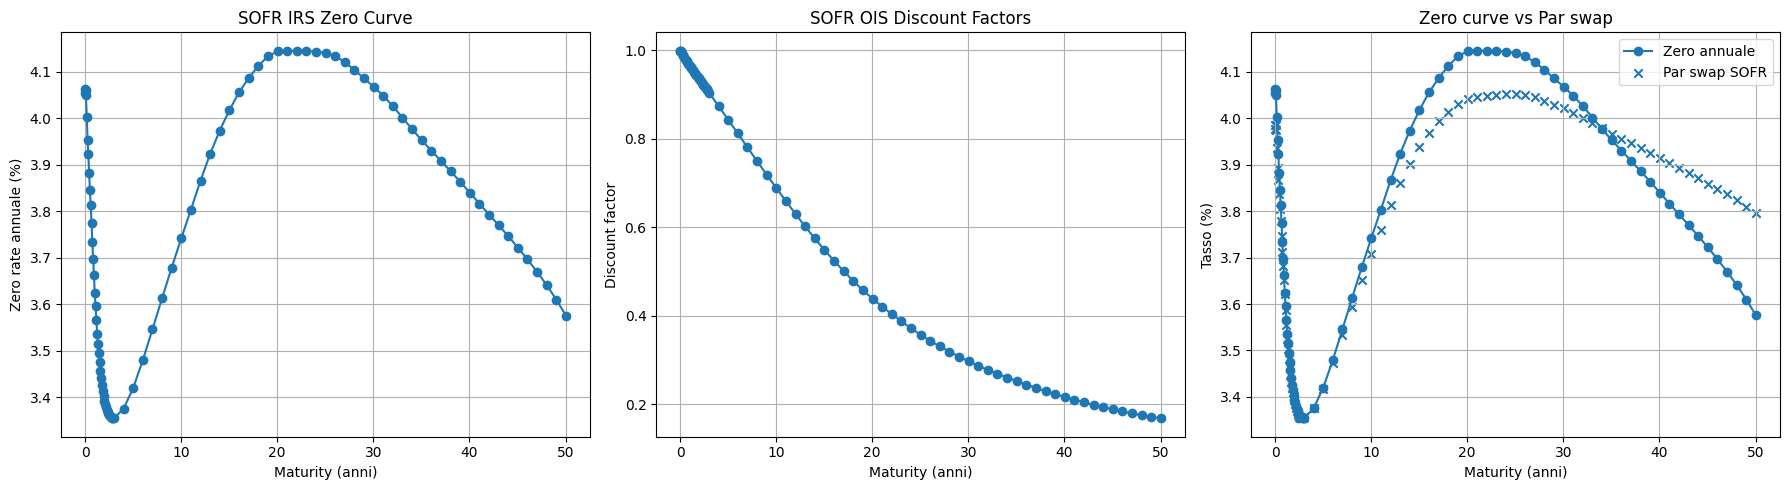

In [83]:
import matplotlib.pyplot as plt

# Aggiungo la colonna in anni
df_curve["T_years"] = (df_curve["Termination"] - trade_date).dt.days / 365.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -----------------------------
# 1) Zero curve annualizzata
# -----------------------------
axes[0].plot(df_curve["T_years"], df_curve["Zero_annual"]*100, marker="o")
axes[0].set_xlabel("Maturity (anni)")
axes[0].set_ylabel("Zero rate annuale (%)")
axes[0].set_title("SOFR IRS Zero Curve")
axes[0].grid(True)

# -----------------------------
# 2) Discount Factors
# -----------------------------
axes[1].plot(df_curve["T_years"], df_curve["DF"], marker="o")
axes[1].set_xlabel("Maturity (anni)")
axes[1].set_ylabel("Discount factor")
axes[1].set_title("SOFR OIS Discount Factors")
axes[1].grid(True)

# -----------------------------
# 3) Zero vs Par Swap
# -----------------------------
axes[2].plot(df_curve["T_years"], df_curve["Zero_annual"]*100,
             marker="o", label="Zero annuale")
axes[2].scatter(df_curve["T_years"], df_curve["Par_rate_%"],
                marker="x", label="Par swap SOFR")
axes[2].set_xlabel("Maturity (anni)")
axes[2].set_ylabel("Tasso (%)")
axes[2].set_title("Zero curve vs Par swap")
axes[2].grid(True)
axes[2].legend()


plt.tight_layout()
plt.show()